In [1]:
%config Completer.use_jedi = False

In [2]:
import sys
from model import atp_graph, atp_pipeline, model_init
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import os
plt.style.use('ggplot')
import pandas as pd
%matplotlib inline
from data_wrangler import batcher
import warnings
warnings.filterwarnings("ignore")
import math as m

In [3]:
gcm_nigeria = pd.read_csv("/Users/omernivron/Downloads/hw2/ipsl.csv").iloc[:, 3:]
era_nigeria = pd.read_csv("/Users/omernivron/Downloads/hw2/era.csv").iloc[:, 4:]

In [ ]:
era_nigeria = era_nigeria[(era_nigeria.year >= 1948) & (era_nigeria.year < 2015)]
gcm_nigeria = gcm_nigeria[(gcm_nigeria.year >= 1948) & (gcm_nigeria.year < 2015) & (gcm_nigeria.axis_nbounds == 0)]

In [ ]:
df = gcm_nigeria.groupby(['lat', 'lon']).mean().reset_index()
df['loc_key'] = np.arange(df.shape[0])
df = df[['lat', 'lon', 'loc_key']]
gcm_nigeria = pd.merge(gcm_nigeria, df, how='left', on=['lat', 'lon'])

In [ ]:
df_e = era_nigeria.groupby(['lat', 'lon']).mean().reset_index()
df_e['loc_key'] = np.arange(df_e.shape[0])
df_e = df_e[['lat', 'lon', 'loc_key']]
era_nigeria = pd.merge(era_nigeria, df_e, how='left', on=['lat', 'lon'])

In [ ]:
era_nigeria['t'] = era_nigeria['year'] + ((era_nigeria['month'] - 1)/ 12) + ((era_nigeria['day'] - 1)/ (12 *31))
gcm_nigeria['t'] = gcm_nigeria['year'] + ((gcm_nigeria['month'] - 1)/ 12)+ ((gcm_nigeria['day'] - 1)/ (12 *31))

In [ ]:
era_mon_nigeria = era_nigeria.groupby(['grid_val','loc_key','t']).mean().reset_index()
gcm_mon_nigeria = gcm_nigeria.groupby(['grid_val','loc_key', 't']).mean().reset_index()

In [ ]:
era_mon_nigeria['tmax'] = era_mon_nigeria['tmax'] - 273.15 
gcm_mon_nigeria['tasmax'] = gcm_mon_nigeria['tasmax'] - 273.15 

In [ ]:
μ_era_past = era_mon_nigeria[(era_mon_nigeria.t > 1948) & (era_mon_nigeria.t  < 1988)].groupby(['grid_val', 'loc_key']).mean()['tmax'].reset_index()
μ_gcm_past = gcm_mon_nigeria[(gcm_mon_nigeria.t > 1948) & (gcm_mon_nigeria.t  < 1988)].groupby(['grid_val', 'loc_key']).mean()['tasmax'].reset_index()

σ_era_past = era_mon_nigeria[(era_mon_nigeria.t > 1948) & (era_mon_nigeria.t  < 1988)].groupby(['grid_val', 'loc_key']).std()['tmax'].reset_index()
σ_gcm_past = gcm_mon_nigeria[(gcm_mon_nigeria.t > 1948) & (gcm_mon_nigeria.t  < 1988)].groupby(['grid_val', 'loc_key']).std()['tasmax'].reset_index()

In [ ]:
era_mon_nigeria = pd.merge(era_mon_nigeria, μ_era_past, on=['grid_val', 'loc_key'], how='left', suffixes=('', '_mu'))
era_mon_nigeria = pd.merge(era_mon_nigeria, σ_era_past, on=['grid_val', 'loc_key'], how='left', suffixes=('', '_sigma'))


In [ ]:
gcm_mon_nigeria = pd.merge(gcm_mon_nigeria, μ_gcm_past, on=['grid_val', 'loc_key'], how='left', suffixes=('', '_mu'))
gcm_mon_nigeria = pd.merge(gcm_mon_nigeria, σ_gcm_past, on=['grid_val', 'loc_key'], how='left', suffixes=('', '_sigma'))

In [ ]:
era_mon_nigeria = era_mon_nigeria[era_mon_nigeria.grid_val!=25]
era_mon_nigeria = era_mon_nigeria[era_mon_nigeria.grid_val!=8]
gcm_mon_nigeria = gcm_mon_nigeria[gcm_mon_nigeria.grid_val!=25]

In [ ]:
era_mon_nigeria['era_adj_tmax'] = (era_mon_nigeria.tmax - era_mon_nigeria.tmax_mu) / era_mon_nigeria.tmax_sigma 
gcm_mon_nigeria['gcm_adj_tasmax'] = (gcm_mon_nigeria.tasmax - gcm_mon_nigeria.tasmax_mu) / gcm_mon_nigeria.tasmax_sigma

In [ ]:
era_mon_nigeria 

,grid_val,loc_key,t,lat,lon,year,month,day,tmax,tmax_mu,tmax_sigma,era_adj_tmax
0,7,4,1948.000000,6.66657,5.625,1948.0,1.0,1.0,25.65000,25.736254,1.984310,-0.043468
1,7,4,1948.002688,6.66657,5.625,1948.0,1.0,2.0,25.19998,25.736254,1.984310,-0.270257
2,7,4,1948.005376,6.66657,5.625,1948.0,1.0,3.0,25.85000,25.736254,1.984310,0.057322
3,7,4,1948.008065,6.66657,5.625,1948.0,1.0,4.0,26.82500,25.736254,1.984310,0.548677
4,7,4,1948.010753,6.66657,5.625,1948.0,1.0,5.0,26.47500,25.736254,1.984310,0.372293
...,...,...,...,...,...,...,...,...,...,...,...,...
367075,24,15,2014.986559,10.47604,11.250,2014.0,12.0,27.0,23.90000,28.372395,4.070516,-1.098729
367076,24,15,2014.989247,10.47604,11.250,2014.0,12.0,28.0,25.82500,28.372395,4.070516,-0.625816
367077,24,15,2014.991935,10.47604,11.250,2014.0,12.0,29.0,26.70000,28.372395,4.070516,-0.410856
367078,24,15,2014.994624,10.47604,11.250,2014.0,12.0,30.0,27.85000,28.372395,4.070516,-0.128336


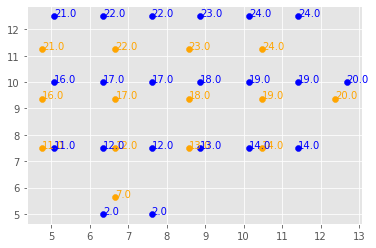

In [ ]:

a = era_mon_nigeria.groupby(['lat', 'lon']).mean().reset_index()
b = gcm_mon_nigeria.groupby(['lat', 'lon']).mean().reset_index()
plt.scatter(a['lat'], a['lon'], c='orange')
plt.scatter(b['lat'], b['lon'], c='b') 
for i in range(a.shape[0]):
    plt.text(a['lat'][i], a['lon'][i], str(a['grid_val'][i]), c='orange')
for i in range(b.shape[0]):
    plt.text(b['lat'][i], b['lon'][i], str(b['grid_val'][i]), c='b')

In [ ]:
# prepare data for batcher_bc
array = pd.merge(era_mon_nigeria, gcm_mon_nigeria, on=['grid_val', 't'], how='inner', suffixes=('', '_gcm'))
### check if merge is correct
# array.loc[array.grid_val==r_grid_val, ['loc_key', 'loc_key_gcm', 't', 'adj_tmax', 'adj_tasmax']]
####

In [ ]:
m = model_init.model_init('leak', 2, 'forecasting/bc/', multiply = 2, bc=True, subsample = False)
m.load_model()

(<tensorflow.python.training.tracking.util.Checkpoint at 0x3d817b910>,
 <tensorflow.python.training.checkpoint_management.CheckpointManager at 0x5873c12e0>)

In [ ]:
r_grid_val = np.random.choice(np.unique(array.grid_val), 1)[0]
r_loc_key = np.random.choice(np.unique(array.loc[array.grid_val==r_grid_val, ['loc_key_gcm']]), 1)[0]
arr_temp = array.loc[(array.grid_val==r_grid_val) & (array.loc_key_gcm == r_loc_key), ['t', 'gcm_adj_tasmax', 'era_adj_tmax']].reset_index(drop=True)
x, y = batcher.batcher_bc(np.array(arr_temp.reset_index(drop=True)), 180)

In [ ]:
m.model.MHAX_leakage

AttributeError: 'atp_pipeline' object has no attribute 'MHAX_leakage'

In [ ]:
m  = atp_pipeline.atp_pipeline(multiply=2, MHAX_leakage=True, subsample=False, bc=True)

MHAX_leakage


In [ ]:
n_C = [180, 90]
n_T = [0, 90]
n_C_s = [0, 0]
n_T_s = [0, 0]
m([x[:, :, np.newaxis], y, n_C, n_T, True, n_C_s, n_T_s])

(<tf.Tensor: shape=(32, 0, 1), dtype=float32, numpy=array([], shape=(32, 0, 1), dtype=float32)>,
 <tf.Tensor: shape=(32, 0, 1), dtype=float32, numpy=array([], shape=(32, 0, 1), dtype=float32)>)

In [23]:
x.shape

(32, 360)

In [21]:
        n_C = 90
        n_T = 90
        subsample = False
        n_C_s, n_T_s  = 0, 0
        x = x[:,:(n_C+n_T) * 2][:, :, np.newaxis]
        y = y[:,:(n_C+n_T) * 2,:]

In [22]:
    def concat_context_multi_ts(list_of_inputs, dim, n_C):
        return tf.concat([list_of_inputs[i][dim][:, :n_C, :] for i in range(len(list_of_inputs))], axis=1)

    def concat_target_multi_ts(list_of_inputs, dim, n_C, n_T, last_dim):
        x = tf.concat([list_of_inputs[i][dim][:, n_C:n_C+n_T, :][:, :, tf.newaxis, :] for i in range(len(list_of_inputs))], axis=2)
        x = tf.reshape(x, (x.shape[0], -1, last_dim))
        return x

In [23]:
from data_wrangler import feature_extractor

In [24]:
f = feature_extractor.feature_wrapper()
de = feature_extractor.DE()

In [25]:
n_C = [180, 90]
n_T = [0, 90]
batch_size = x.shape[0]
inputs_for_processing = []
eye = tf.eye(2)
for i in range(2):
    # embed each ts separately and each dimension separately
    ts_label = tf.reshape(tf.repeat(eye[:, i][tf.newaxis, :], batch_size*(n_C[i] + n_T[i]), axis=0), (batch_size, -1, 2)) # one hot encoding of the ts
    ts_start = i*(n_C[i] + n_T[i])
    ts_end = (i+1)*(n_C[i] + n_T[i])


    x_temp = x[:, ts_start:ts_end, :]
    y_temp = y[:, ts_start:ts_end, :]

    x_emb = [tf.concat([f.PE([x_temp[:, :, dim_num][:, :, tf.newaxis], 10, 0.1, 2]), ts_label], axis=-1) for dim_num in range(x_temp.shape[-1])] 
    x_emb = tf.concat(x_emb, axis=-1) # (32, 30, 34)
    # take derivative of each ts separately
    y_diff, x_diff, d, x_n, y_n = de([y_temp, x_temp, n_C[i], n_T[i], True]) #  (32, 30, 1),  (32, 30, 1), (32, 30, 2), (32, 30, 1), (32, 30, 1)

    inputs_for_processing.append([x_emb, y_temp, y_diff, x_diff, d, x_n, y_n])  



In [27]:
context_list = [concat_context_multi_ts(inputs_for_processing, j, n_C[0] + n_T[0]) for j in range(7)]


In [29]:
context_list[0].shape
n_C[0] + n_T[0] + n_C[1] 

270

In [26]:
inputs_for_processing[1][0].shape

TensorShape([32, 180, 12])

In [ ]:
# the end sequence will be (y_11,.., y_1n_C, y21, ..y_2n_C2, y1*, y1**, ...,y1****)


In [ ]:

context_list = [self.concat_context_multi_ts(inputs_for_processing, j, n_C) for j in range(7)]
target_list = [self.concat_target_multi_ts(inputs_for_processing, j, n_C, n_T, context_list[j].shape[-1]) for j in range(7)]
x_emb, y, y_diff, x_diff, d, x_n, y_n = [tf.concat([context_list[j], target_list[j]], axis=1) for j in range(7)]